In [1]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='../msdf/data/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.371 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
first_sample_token = nusc.scene[0]['first_sample_token']
# nusc.render_sample(first_sample_token)

In [3]:
sample = nusc.get('sample', first_sample_token)
sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [5]:
lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
lidar_data

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402927647951,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin',
 'prev': '',
 'next': '0cedf1d2d652468d92d23491136b5d15',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [6]:
annotation_metadata = nusc.get('sample_annotation', sample['anns'][1])
annotation_metadata

{'token': '6b89da9bf1f84fd6a5fbe1c3b236f809',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '48d58b69b40149aeb2e64aa4b1a9192f',
 'visibility_token': '2',
 'attribute_tokens': ['ab83627ff28b465b85c427162dec722f'],
 'translation': [378.888, 1153.348, 0.865],
 'size': [0.775, 0.769, 1.711],
 'rotation': [-0.5527590208259255, 0.0, 0.0, 0.8333411455673865],
 'prev': '',
 'next': '216bbbd8e01c450a8fabe9d47433c10a',
 'num_lidar_pts': 2,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

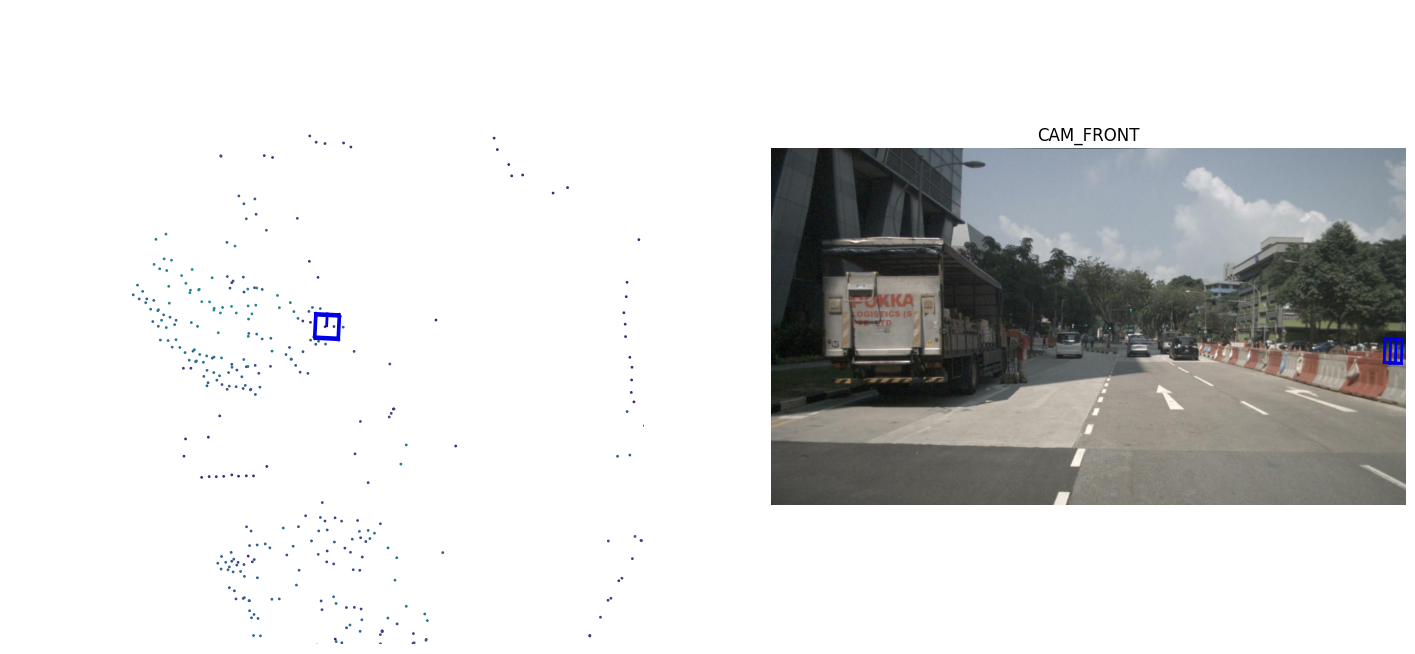

In [7]:
nusc.render_annotation(annotation_metadata['token'])

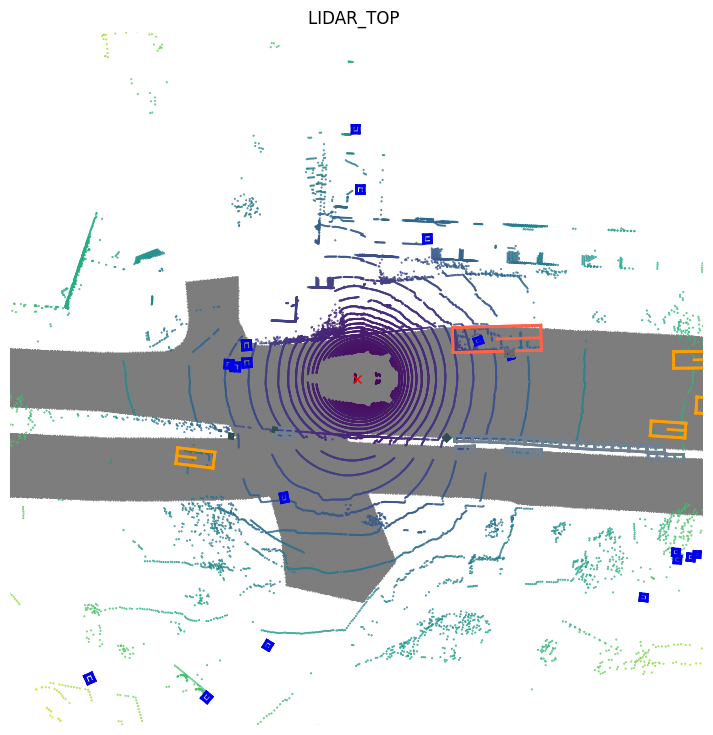

In [8]:
nusc.render_sample_data(lidar_data['token'], with_anns=True)

In [12]:
import concurrent.futures
import itertools
import numpy as np
from PIL import Image

def filter_sample(sample, sensor_type="lidar"):        
    camera = [
        'CAM_FRONT',
        'CAM_FRONT_LEFT',
        'CAM_FRONT_RIGHT',
        'CAM_BACK',
        'CAM_BACK_LEFT',
        'CAM_BACK_RIGHT'
    ]
    radar = [
        'RADAR_FRONT',
        'RADAR_FRONT_LEFT',
        'RADAR_FRONT_RIGHT',
        'RADAR_BACK_LEFT',
        'RADAR_BACK_RIGHT'
    ]
    lidar = ['LIDAR_TOP']
    if sensor_type == "lidar": sensors = lidar
    if sensor_type == "radar": sensors = radar
    if sensor_type == "camera": sensors = camera
    else: sensors = camera + lidar + radar
    data = []
    for sensor in sensors:
        image_path, boxes, _ = nusc.get_sample_data(sample['data'][sensor])
        data.append((image_path, boxes))
    return data

def get_data(scene):
    sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = []
    while sample_token != last_sample_token:
        samples.append(nusc.get('sample', sample_token))
        sample_token = samples[-1]['next']

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(filter_sample, samples)

    return list(itertools.chain(*results))     

def compute(image_path, boxes):
    image = np.asarray(Image.open(image_path).resize((512, 512)))
    boxes = [(box.name, box.center, box.wlh) for box in boxes]
    return image, boxes

def dataset(scene, batch_size=64):
    data = get_data(scene)
    i = 0
    while i < len(data):
        batch = data[i : i + batch_size]
        yield [i, b for i, b in batch]
        i += batch_size

In [13]:
ds = dataset(nusc.scene[0])

In [14]:
len(next(ds))

UnidentifiedImageError: cannot identify image file '../msdf/data/nuscenes/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin'